## Sistema de predicción de ventas


#### Paso 1: Cargar del conjunto de datos


In [1]:
import pandas as pd

# Cargar datos
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df = pd.read_csv(url)

# Ver las primeras filas
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


No hay datos nulos


In [3]:
df['date'] = pd.to_datetime(df['date'])  # Asegura que la columna 'date' sea datetime
df.set_index('date', inplace=True) # Establecer la columna de fecha como índice
df = df.sort_index()  # Ordenar por fecha si no lo está


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-03 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


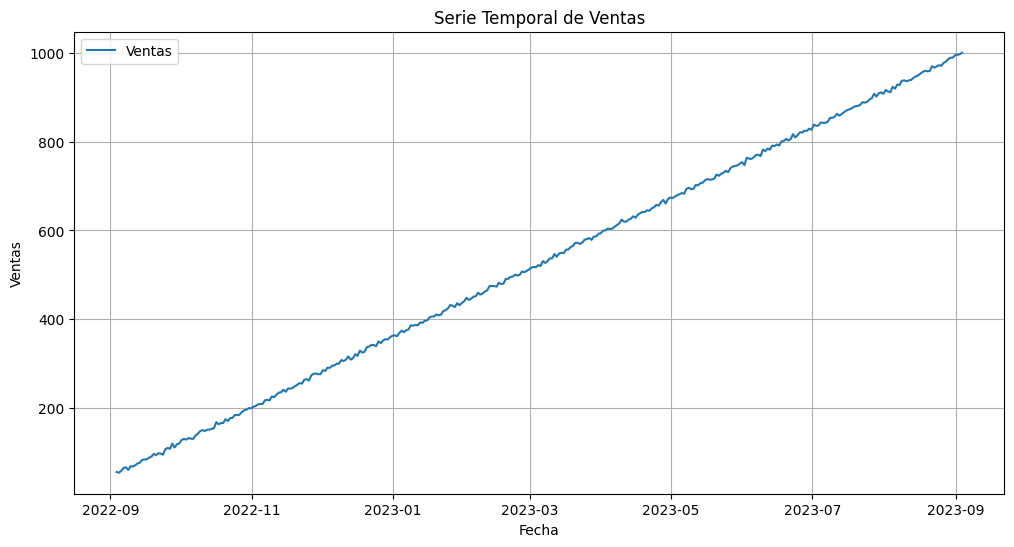

In [5]:
#Gráfico

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['sales'], label='Ventas')
plt.title('Serie Temporal de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()


**Análisis del gráfico**

**Tendencia clara y creciente**

        Las ventas aumentan de forma sostenida y prácticamente lineal a lo largo del tiempo.

**No se aprecia estacionalidad evidente**

        No hay ciclos visibles (ni semanales ni mensuales).

**Ruido bajo**

        Aunque hay pequeñas variaciones día a día, la línea es muy suave.

### Paso 2: Construir y analizar la serie temporal

**¿Cuál es el tensor de la serie temporal?**

In [6]:
df['sales'].shape  # Muestra la dimensión del tensor (número de observaciones)

(366,)

Tenemos un DatetimeIndex que va de 2022-09-03 a 2023-09-03.

Con 366 observaciones, lo que implica que es una serie diaria durante un año.

In [7]:
import numpy as np

tensor = df['sales'].values  # Esto sería el "tensor" de ventas
tensor

array([  55.29215704,   53.80321135,   58.1416934 ,   64.53089878,
         66.01363287,   60.08186499,   68.46670361,   67.76510646,
         70.51226125,   74.65645304,   76.45952797,   82.99295751,
         83.51598989,   84.20064149,   87.76994586,   90.04211887,
         96.12607284,   93.63110055,   97.78851817,   96.88976758,
         94.39582507,  106.61839003,  109.85358257,  107.63651864,
        119.2750173 ,  110.70539613,  117.80850843,  119.71242105,
        127.47504997,  129.88752836,  128.54703406,  131.81941907,
        130.62431399,  129.94802155,  137.44941424,  141.56493732,
        147.38950218,  149.90850941,  147.74212914,  150.59994106,
        150.96393015,  152.45227496,  154.19625792,  167.7701344 ,
        162.9915914 ,  165.80906477,  165.96764132,  174.66123819,
        170.08981331,  176.89602573,  177.45058662,  183.90043352,
        183.81005034,  184.40330893,  190.46339852,  194.43568054,
        195.95297632,  199.26358008,  199.05593783,  202.47342

**¿Cuál es la tendencia?**

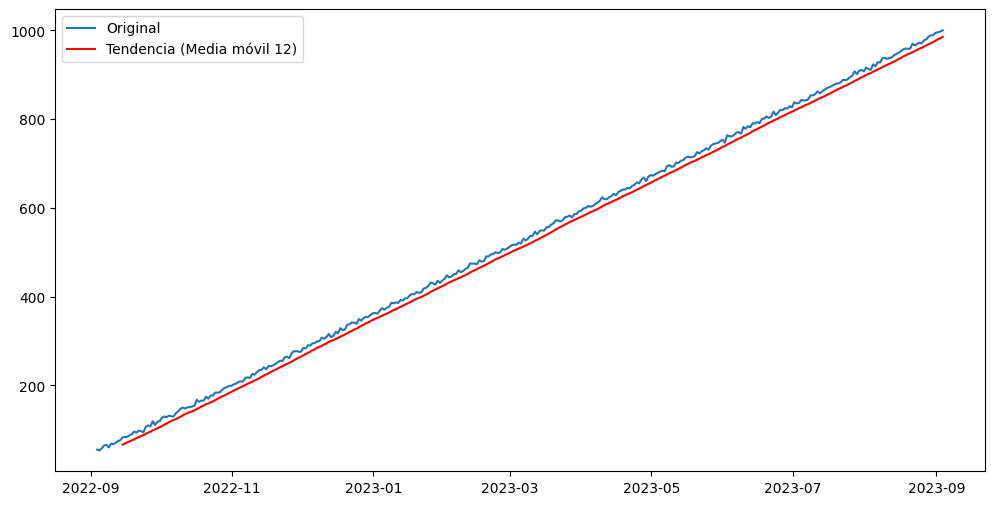

In [8]:
df['rolling_mean'] = df['sales'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['sales'], label='Original')
plt.plot(df['rolling_mean'], label='Tendencia (Media móvil 12)', color='red')
plt.legend()
plt.show()

La línea roja (media móvil) sigue de forma muy ajustada a la serie original.

Esto confirma que hay una tendencia creciente fuerte y estable, sin cambios bruscos.


**¿Es estacionaria?**

Una serie es estacionaria si su media, varianza y covarianza no cambian con el tiempo. Para comprobarlo, usamos el test de Dickey-Fuller aumentado (ADF)

Si el p-value < 0.05, la serie es estacionaria.

Si el p-value >= 0.05, no es estacionaria.

In [9]:
!pip install statsmodels



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['sales'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: 0.545414193706378
p-value: 0.9861899815311064


El p-value es muy alto (0.986 > 0.05): la serie NO es estacionaria

Esto quiere decir que:

    La media y/o la varianza cambian con el tiempo.

    Podría haber tendencia o estacionalidad persistente.

    Es probable que necesitemos diferenciar la serie o transformarla para aplicar modelos como ARIMA.

**¿Existe variabilidad o ruido?**

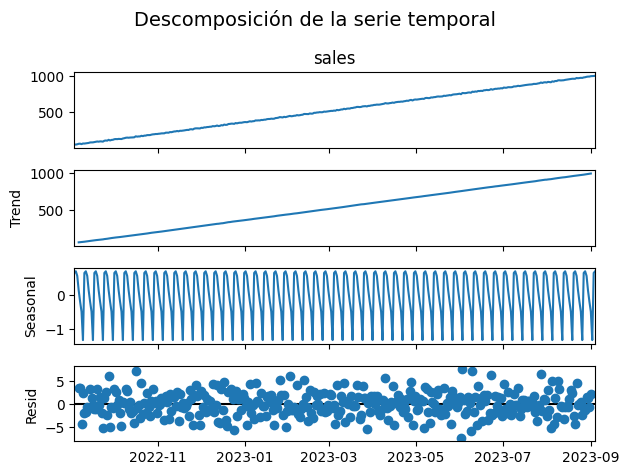

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomposición aditiva
decomposition = seasonal_decompose(df['sales'], model='additive', period=7)  # periodo semanal asumido

# Graficar componentes
decomposition.plot()
plt.suptitle('Descomposición de la serie temporal', fontsize=14)
plt.tight_layout()
plt.show()


**Análisis de los gráficos**

 **Tendencia (Trend)**

        Claramente creciente.

        Esto confirma que la serie no es estacionaria, ya que hay un cambio sistemático en el nivel de las ventas a lo largo del tiempo.

**Estacionalidad (Seasonal):**

        Se observa un patrón cíclico regular y bastante pronunciado.

        Parece ser estacionalidad semanal o mensual, con oscilaciones regulares.

**Ruido (Resid):**

        Fluctúan en torno a cero, sin patrón aparente → esto es lo que esperamos del ruido aleatorio.

        La variabilidad es moderada, con la mayoría de los puntos dentro de ±5.

        El componente residual parece ser ruido blanco → no hay indicios de errores sistemáticos.





In [12]:
# Diferenciación de primer orden
df['sales_diff'] = df['sales'].diff()

# Eliminar el primer valor NaN que genera la diferencia
df_diff = df['sales_diff'].dropna()


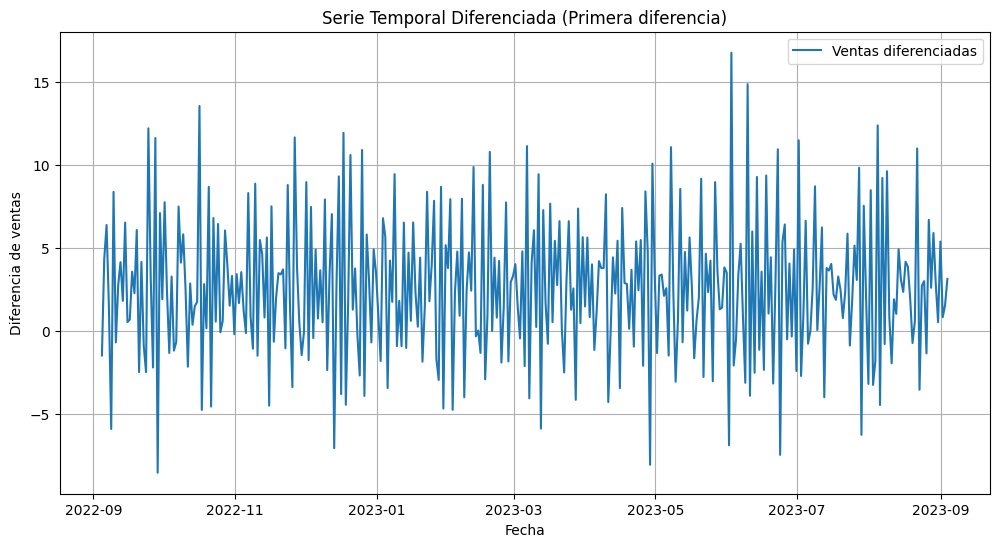

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_diff, label='Ventas diferenciadas')
plt.title('Serie Temporal Diferenciada (Primera diferencia)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de ventas')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
from statsmodels.tsa.stattools import adfuller

adf_result_diff = adfuller(df_diff)
print("ADF Statistic (diferenciada):", adf_result_diff[0])
print("p-value (diferenciada):", adf_result_diff[1])


ADF Statistic (diferenciada): -9.430263118334729
p-value (diferenciada): 5.212954111417404e-16


Conclusión: la serie diferenciada ES ESTACIONARIA

### Paso 3: Entrenar un ARIMA

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

In [16]:
model = pm.auto_arima(df['sales'],
                      seasonal=False,
                      stepwise=True,
                      suppress_warnings=True,
                      trace=True)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.07 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.02 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.20 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.45 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.21 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.07 sec


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.440 seconds


El mejor modelo es el (1,1,1)

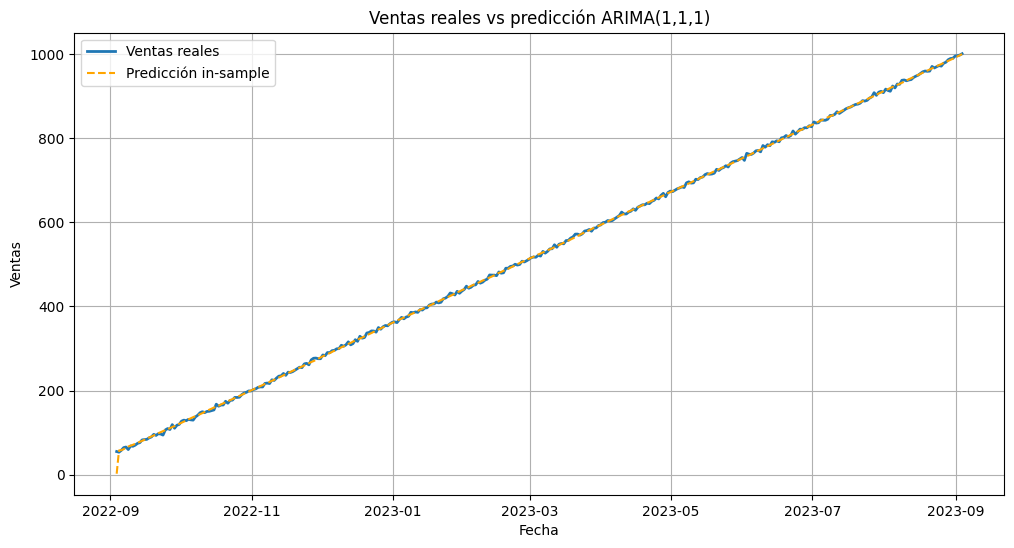

In [17]:
import matplotlib.pyplot as plt

# Obtener predicciones in-sample del modelo
y_pred = model.predict_in_sample()
y_true = df['sales'].iloc[-len(y_pred):]  # ajustar tamaño para que coincidan

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true, label='Ventas reales', linewidth=2)
plt.plot(y_true.index, y_pred, label='Predicción in-sample', linestyle='--', color='orange')
plt.title('Ventas reales vs predicción ARIMA(1,1,1)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()



Ese gráfico muestra perfectamente la comparación entre las ventas reales y la predicción del modelo ARIMA(1,1,1) sobre los mismos datos.

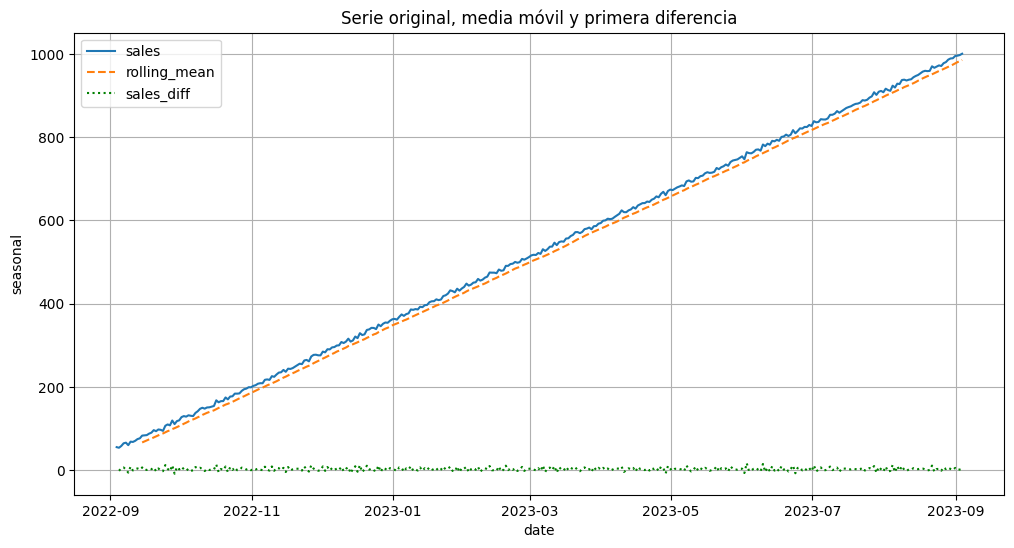

In [18]:
import matplotlib.pyplot as plt

# Calcular media móvil
df['rolling_mean'] = df['sales'].rolling(window=12).mean()

# Calcular la primera diferencia
df['sales_diff'] = df['sales'].diff()

# Graficar todo junto
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['sales'], label='sales')
plt.plot(df.index, df['rolling_mean'], label='rolling_mean', linestyle='--')
plt.plot(df.index, df['sales_diff'], label='sales_diff', linestyle=':', color='green')
plt.title('Serie original, media móvil y primera diferencia')
plt.xlabel('date')
plt.ylabel('seasonal')
plt.legend()
plt.grid(True)
plt.show()


Este gráfico es útil para ver la tendencia (media móvil) y cómo la diferenciación elimina la tendencia, dejando una serie más estacionaria.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [20]:

y_true = df['sales'].iloc[1:]  # Omitimos el primer valor (por la diferenciación)
y_pred = model.predict_in_sample()


In [21]:
# Predicciones in-sample
y_pred = model.predict_in_sample()

# Recortar los valores reales al mismo tamaño que las predicciones
y_true = df['sales'].iloc[-len(y_pred):]


In [22]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

MAE:  2.55
RMSE: 4.05
R²:   0.9998


**MAE:	2.55**	El modelo se equivoca en promedio solo 2.55 unidades de venta → muy bajo.  
**RMSE:	4.05**	Error algo más sensible a valores extremos, pero también bajo.  
**R²: 0.9998**	El modelo explica el 99.98% de la variabilidad de las ventas → excelente ajuste.  

### Paso 4: Predicir con el conjunto de test

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


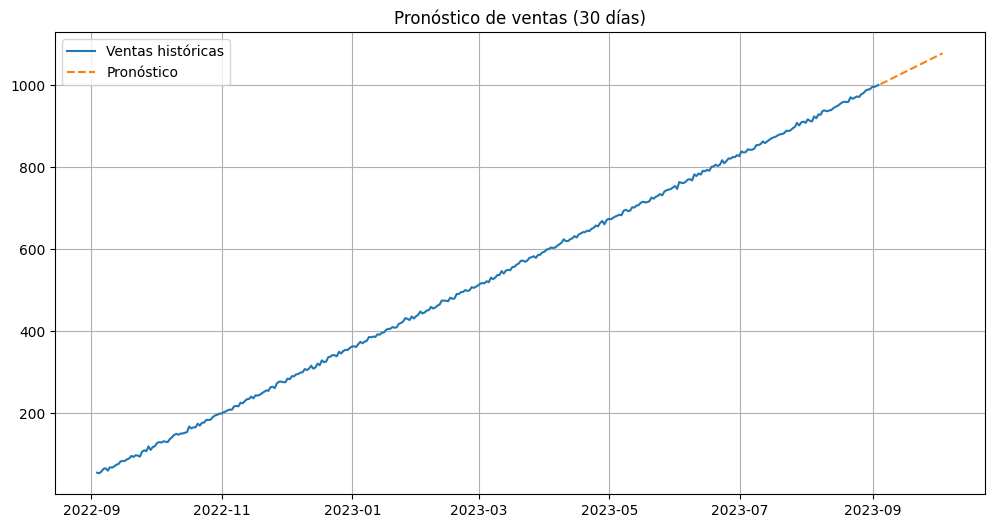

In [23]:
# Predecir 30 días futuros
forecast = model.predict(n_periods=30)

# Crear fechas futuras
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

# Crear DataFrame de predicción
forecast_df = pd.DataFrame({'Fecha': future_dates, 'Pronóstico': forecast})
forecast_df.set_index('Fecha', inplace=True)

# Visualizar
plt.figure(figsize=(12, 6))
plt.plot(df['sales'], label='Ventas históricas')
plt.plot(forecast_df, label='Pronóstico', linestyle='--')
plt.title('Pronóstico de ventas (30 días)')
plt.legend()
plt.grid(True)
plt.show()

### Paso 5: Guardar el modelo

In [24]:
import joblib
import os

# Crear carpeta si no existe
os.makedirs("modelos", exist_ok=True)

# Guardar el modelo ARIMA
joblib.dump(model, "modelos/modelo_arima_1_1_1.pkl")

print(" Modelo ARIMA almacenado en 'modelos/modelo_arima_1_1_1.pkl'")


 Modelo ARIMA almacenado en 'modelos/modelo_arima_1_1_1.pkl'
